In [1]:
# === Cell 1: Imports and Constants ===
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import AutoTokenizer, T5ForConditionalGeneration
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import open_clip

# Paths
IMAGE_DIR = "mini_dataset_100/images"
REPORT_DIR = "mini_dataset_100/reports"
SPLITS_FILE = "mini_dataset_100/splits.csv"
LABELS_FILE = "mini_dataset_100/chexpert_labels.csv"
OUTPUT_CSV = "mini_dataset_100/train_data_multilabel_with_reports.csv"

# Constants
LABEL_COLS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Enlarged Cardiomediastinum",
    "Fracture", "Lung Lesion", "Lung Opacity", "No Finding", "Pleural Effusion",
    "Pleural Other", "Pneumonia", "Pneumothorax", "Support Devices"
]
MAX_TEXT_LEN = 256
BATCH_SIZE = 4
EPOCHS = 5


2025-06-12 14:06:26.290778: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 14:06:26.468761: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-12 14:06:36.185672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# === Cell 2: Validate and Build Image–Report Dataset ===
split_df = pd.read_csv(SPLITS_FILE)

records = []
for _, row in split_df.iterrows():
    dicom_id = row["dicom_id"]
    study_id = row["study_id"]
    image_path = os.path.join(IMAGE_DIR, f"{dicom_id}.jpg")
    report_path = os.path.join(REPORT_DIR, f"s{study_id}.txt")

    if os.path.exists(image_path) and os.path.exists(report_path):
        with open(report_path, "r", encoding="utf-8") as f:
            report = f.read().strip()
        records.append({
            "image_path": image_path,
            "report": report,
            "study_id": study_id,
            "dicom_id": dicom_id,
            "subject_id": row["subject_id"],
            "split": row["split"]
        })

df = pd.DataFrame(records)
print(f"✅ Valid image-report pairs found: {len(df)}")


✅ Valid image-report pairs found: 4000


In [3]:
# === Cell 3: Merge Multi-labels and Preprocess ===
labels_df = pd.read_csv(LABELS_FILE)

# Merge image-report data with CheXpert labels
df = pd.merge(df, labels_df, on=["subject_id", "study_id"], how="inner")

# Drop dummy label columns (with _x suffix)
df = df.drop(columns=[col for col in df.columns if col.endswith('_x')])

# Rename label columns with _y suffix back to original names
df = df.rename(columns={f"{col}_y": col for col in LABEL_COLS})

# Clean label values: replace -1 with 0, fill NaNs, convert to int
df[LABEL_COLS] = df[LABEL_COLS].replace(-1, 0)
df[LABEL_COLS] = df[LABEL_COLS].fillna(0).astype(int)

# Save for reuse
df.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Final multi-label dataset saved: {OUTPUT_CSV}")


✅ Final multi-label dataset saved: mini_dataset_100/train_data_multilabel_with_reports.csv


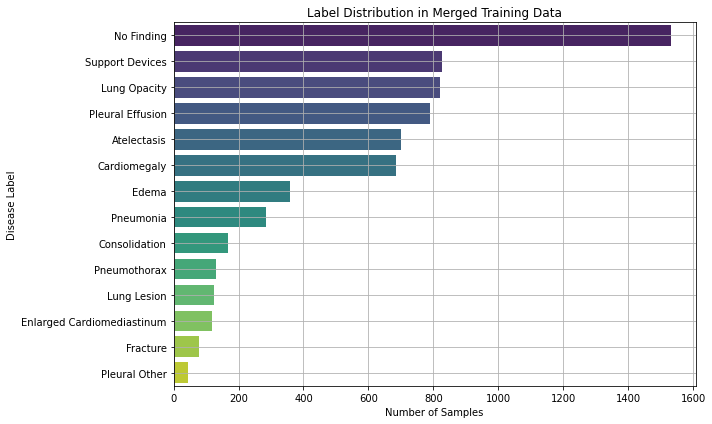

📊 Report Length Stats (in words):
count    4000.000000
mean       86.336250
std        35.422689
min        16.000000
25%        62.000000
50%        78.000000
75%       102.000000
max       291.000000
Name: report_len, dtype: float64


/tmp/ipykernel_6192/2976305284.py:26: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/opt/ohpc/pub/apps/python/3.8.12/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


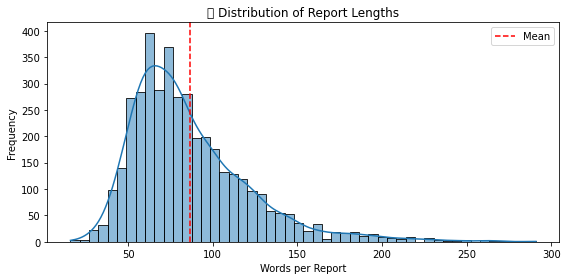

/tmp/ipykernel_6192/2976305284.py:40: UserWarning: Glyph 128221 (\N{MEMO}) missing from current font.
  plt.tight_layout()
/opt/ohpc/pub/apps/python/3.8.12/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


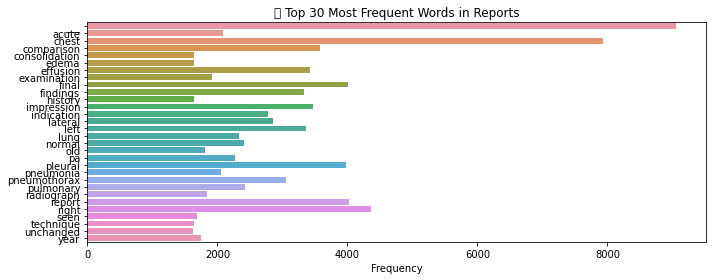

In [4]:
# === Cell 4: Label Distribution + Report Text Analysis ===

# Label distribution
label_counts = df[LABEL_COLS].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.values, y=label_counts.index, palette="viridis")
plt.title("Label Distribution in Merged Training Data")
plt.xlabel("Number of Samples")
plt.ylabel("Disease Label")
plt.grid(True)
plt.tight_layout()
plt.show()

# Report length stats
df["report_len"] = df["report"].apply(lambda x: len(x.split()))
print("📊 Report Length Stats (in words):")
print(df["report_len"].describe())

plt.figure(figsize=(8, 4))
sns.histplot(df["report_len"], bins=50, kde=True)
plt.axvline(df["report_len"].mean(), color='red', linestyle='--', label="Mean")
plt.title("📈 Distribution of Report Lengths")
plt.xlabel("Words per Report")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Top report words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=30)
X = vectorizer.fit_transform(df["report"])
word_freq = np.array(X.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 4))
sns.barplot(x=word_freq, y=words)
plt.title("📝 Top 30 Most Frequent Words in Reports")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


In [5]:
import torch

label_counts = df[LABEL_COLS].sum()
neg_counts = len(df) - label_counts

pos_weight = (neg_counts / label_counts).values
pos_weight = torch.tensor(pos_weight, dtype=torch.float32)

print("✅ Computed pos_weight:")
for label, weight in zip(LABEL_COLS, pos_weight):
    print(f"{label:30s} → pos_weight: {weight:.2f}")

✅ Computed pos_weight:
Atelectasis                    → pos_weight: 4.72
Cardiomegaly                   → pos_weight: 4.85
Consolidation                  → pos_weight: 22.95
Edema                          → pos_weight: 10.11
Enlarged Cardiomediastinum     → pos_weight: 32.61
Fracture                       → pos_weight: 50.95
Lung Lesion                    → pos_weight: 31.52
Lung Opacity                   → pos_weight: 3.88
No Finding                     → pos_weight: 1.61
Pleural Effusion               → pos_weight: 4.06
Pleural Other                  → pos_weight: 92.02
Pneumonia                      → pos_weight: 13.04
Pneumothorax                   → pos_weight: 29.53
Support Devices                → pos_weight: 3.84


In [6]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class ImageMultitaskDataset(Dataset):
    def __init__(self, df, preprocess, tokenizer, max_length, label_cols):
        self.df = df.reset_index(drop=True)
        self.preprocess = preprocess  # from open_clip
        self.tokenizer = tokenizer    # from HuggingFace
        self.max_length = max_length
        self.label_cols = label_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # === Image Processing ===
        image = Image.open(row["image_path"]).convert("RGB")
        image_tensor = self.preprocess(image)  # shape: (3, 224, 224)

        # === Multi-label Vector ===
        labels = torch.tensor(row[self.label_cols].values.astype(float), dtype=torch.float32)  # shape: (14,)

        # === Report Tokenization ===
        encoded = self.tokenizer(
            row["report"],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )

        return {
            "pixel_values": image_tensor,                              # for BioMedCLIP
            "labels": labels,                                          # for classification
            "input_ids": encoded.input_ids.squeeze(0),                 # for Clinical-T5 decoder
            "attention_mask": encoded.attention_mask.squeeze(0)        # for Clinical-T5 decoder
        }


In [7]:
from transformers import AutoTokenizer
import open_clip

# === 1. Load Tokenizer and Image Preprocess Function ===
tokenizer = AutoTokenizer.from_pretrained("avikalsingh/Clinical-T5-Base")
_, _, preprocess = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

# === 2. Load DataFrame ===
df = pd.read_csv("mini_dataset_100/train_data_multilabel_with_reports.csv")

# === 3. Create Dataset Instance ===
dataset = ImageMultitaskDataset(df, preprocess, tokenizer, MAX_TEXT_LEN, LABEL_COLS)

# === 4. Inspect One Sample ===
sample = dataset[0]

print("📷 Image tensor shape:", sample['pixel_values'].shape, "| dtype:", sample['pixel_values'].dtype)
print("✅ Labels shape:", sample['labels'].shape, "| dtype:", sample['labels'].dtype)
print("✍️ input_ids shape:", sample['input_ids'].shape, "| dtype:", sample['input_ids'].dtype)
print("🧠 attention_mask shape:", sample['attention_mask'].shape, "| dtype:", sample['attention_mask'].dtype)

# Optional: Inspect some values
print("\nSample report tokens (decoded):")
print(tokenizer.decode(sample['input_ids'], skip_special_tokens=True))
print("\nLabel vector:", sample['labels'].numpy())


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


📷 Image tensor shape: torch.Size([3, 224, 224]) | dtype: torch.float32
✅ Labels shape: torch.Size([14]) | dtype: torch.float32
✍️ input_ids shape: torch.Size([256]) | dtype: torch.int64
🧠 attention_mask shape: torch.Size([256]) | dtype: torch.int64

Sample report tokens (decoded):
FINAL REPORT EXAMINATION: CHEST (PA AND LAT) INDICATION: ___F with new onset ascites // eval for infection TECHNIQUE: Chest PA and lateral COMPARISON: None. FINDINGS: There is no focal consolidation, pleural effusion or pneumothorax. Bilateral nodular opacities that most likely represent nipple shadows. The cardiomediastinal silhouette is normal. Clips project over the left lung, potentially within the breast. The imaged upper abdomen is unremarkable. Chronic deformity of the posterior left sixth and seventh ribs are noted. IMPRESSION: No acute cardiopulmonary process.

Label vector: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# === Load final dataset CSV ===
df = pd.read_csv("mini_dataset_100/train_data_multilabel_with_reports.csv")

# === Split into Train / Val / Test (80/10/10) ===
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# === Create Dataset Objects ===
train_dataset = ImageMultitaskDataset(train_df, preprocess, tokenizer, MAX_TEXT_LEN, LABEL_COLS)
val_dataset   = ImageMultitaskDataset(val_df, preprocess, tokenizer, MAX_TEXT_LEN, LABEL_COLS)
test_dataset  = ImageMultitaskDataset(test_df, preprocess, tokenizer, MAX_TEXT_LEN, LABEL_COLS)

# === Wrap with DataLoaders ===
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# === Sanity check ===
print(f"✅ DataLoader Sizes: Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")


✅ DataLoader Sizes: Train: 800, Val: 100, Test: 100


In [9]:
# === Multitask Loss Setup ===

# Choose GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Classification loss with pos_weight
clf_loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

# Multitask training loop uses both:
# - Classification loss (clf_loss)
# - Report generation loss (gen_loss, auto-computed by decoder)

def compute_multitask_loss(outputs, batch, alpha=1.0, beta=1.0):
    """
    Combines classification loss and generation loss.
    
    Parameters:
    - outputs: model output dict (class_logits, decoder loss)
    - batch: dict with true labels, input_ids, attention_mask
    - alpha, beta: weighting factors

    Returns:
    - total_loss: weighted sum of classification + generation loss
    - individual components for logging
    """
    class_logits, decoder_output = outputs
    clf_loss = clf_loss_fn(class_logits, batch["labels"])
    gen_loss = decoder_output.loss

    total_loss = alpha * clf_loss + beta * gen_loss
    return total_loss, clf_loss.item(), gen_loss.item()



In [10]:
from transformers.modeling_outputs import BaseModelOutput

class ClipMultiTaskModel(nn.Module):
    def __init__(self, clip_encoder, text_decoder, num_labels):
        super().__init__()
        self.vision_encoder = clip_encoder
        embed_dim = getattr(clip_encoder, "embed_dim", 512)

        self.class_head = nn.Linear(embed_dim, num_labels)
        self.proj = nn.Linear(embed_dim, text_decoder.config.d_model)  # 512 → 768
        self.decoder = text_decoder

    def forward(self, images, input_ids=None, attention_mask=None, labels=None, generate=False):
        # === Encode Image ===
        features = self.vision_encoder(images)  # (B, D)
        class_logits = self.class_head(features)  # (B, num_labels)
        encoder_hidden = self.proj(features).unsqueeze(1)  # (B, 1, D_t5)

        # === Generate or Decode ===
        if generate:
            gen_ids = self.decoder.generate(
                encoder_outputs=BaseModelOutput(last_hidden_state=encoder_hidden),
                max_length=MAX_TEXT_LEN,
                num_beams=4,
                early_stopping=True
            )
            return class_logits, gen_ids

        # === Report Generation with Teacher Forcing ===
        outputs = self.decoder(
            labels=input_ids,
            attention_mask=attention_mask,
            encoder_outputs=BaseModelOutput(last_hidden_state=encoder_hidden),
            return_dict=True
        )

        return class_logits, outputs


In [11]:
# === Define Vision Encoder ===
clip_model, _, _ = open_clip.create_model_and_transforms(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
)
vision_encoder = clip_model.visual

# Optional wrapper with pooling if not done earlier
class CLIPVisionWrapper(nn.Module):
    def __init__(self, vision_model):
        super().__init__()
        self.vision = vision_model

    def forward(self, x):
        features = self.vision(x)
        if features.ndim == 4:
            features = features.mean(dim=[2, 3])  # global avg pool
        return features

vision_encoder = CLIPVisionWrapper(vision_encoder)

# === Define Text Decoder ===
decoder = T5ForConditionalGeneration.from_pretrained("avikalsingh/Clinical-T5-Base")

# === Instantiate Multitask Model ===
model = ClipMultiTaskModel(
    clip_encoder=vision_encoder,
    text_decoder=decoder,
    num_labels=len(LABEL_COLS)
).to(device)

# === Optimizer ===
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [12]:
from transformers.modeling_outputs import BaseModelOutput
import nltk
from sklearn.metrics import f1_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def train(model, train_loader, val_loader, clf_loss_fn, optimizer, tokenizer, num_epochs=EPOCHS, alpha=1.0, beta=1.0):
    model.to(device)
    model.train()
    smooth = SmoothingFunction().method4

    for epoch in range(num_epochs):
        total_loss, total_clf_loss, total_gen_loss = 0.0, 0.0, 0.0
        all_preds = []
        all_labels = []
        bleu_scores = []

        for batch in train_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # === Forward ===
            outputs = model(
                images=pixel_values,
                input_ids=input_ids,
                
                attention_mask=attention_mask,
                labels=input_ids,
                generate=False
            )

            # === Loss ===
            loss, clf_loss, gen_loss = compute_multitask_loss(
                outputs,
                batch={"labels": labels, "input_ids": input_ids, "attention_mask": attention_mask},
                alpha=alpha,
                beta=beta
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # === Logging ===
            total_loss += loss.item()
            total_clf_loss += clf_loss
            total_gen_loss += gen_loss

            logits = outputs[0].detach().cpu()
            preds = (torch.sigmoid(logits) > 0.5).int().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

#             # === BLEU Generation ===
#             with torch.no_grad():
#                 vision_feats = model.vision_encoder(pixel_values)
#                 encoder_hidden = model.proj(vision_feats).unsqueeze(1)
#                 enc_output = BaseModelOutput(last_hidden_state=encoder_hidden)

#                 generated_ids = model.decoder.generate(
#                     encoder_outputs=enc_output,
#                     max_length=MAX_TEXT_LEN,
#                     num_beams=1
#                 )

#                 decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
#                 decoded_refs = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

#                 for pred, ref in zip(decoded_preds, decoded_refs):
#                     bleu = sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth)
#                     bleu_scores.append(bleu)

        # === Epoch Metrics ===
        avg_loss = total_loss / len(train_loader)
        avg_clf_loss = total_clf_loss / len(train_loader)
        avg_gen_loss = total_gen_loss / len(train_loader)
        f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
#         bleu_avg = sum(bleu_scores) / len(bleu_scores)

        print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f} | Clf: {avg_clf_loss:.4f} | Text: {avg_gen_loss:.4f} | F1_micro: {f1_micro:.4f}")


In [13]:
# === Run Training ===

train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    clf_loss_fn=clf_loss_fn,
    optimizer=optimizer,
    tokenizer=tokenizer,
    num_epochs=20,
    alpha=1.0,   # weight for classification loss
    beta=1.0     # weight for report generation loss
)


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


[Epoch 1] Loss: 4.4787 | Clf: 1.2320 | Text: 3.2467 | F1_micro: 0.2558
[Epoch 2] Loss: 2.3802 | Clf: 1.1623 | Text: 1.2180 | F1_micro: 0.3252
[Epoch 3] Loss: 2.1287 | Clf: 1.0799 | Text: 1.0489 | F1_micro: 0.3194
[Epoch 4] Loss: 1.9626 | Clf: 0.9953 | Text: 0.9674 | F1_micro: 0.3518
[Epoch 5] Loss: 1.7618 | Clf: 0.8354 | Text: 0.9265 | F1_micro: 0.4091
[Epoch 6] Loss: 1.5648 | Clf: 0.6595 | Text: 0.9053 | F1_micro: 0.4940
[Epoch 7] Loss: 1.4044 | Clf: 0.5205 | Text: 0.8838 | F1_micro: 0.5587
[Epoch 8] Loss: 1.2825 | Clf: 0.4268 | Text: 0.8557 | F1_micro: 0.6149
[Epoch 9] Loss: 1.2715 | Clf: 0.4208 | Text: 0.8507 | F1_micro: 0.6236
[Epoch 10] Loss: 1.2051 | Clf: 0.3717 | Text: 0.8334 | F1_micro: 0.6626
[Epoch 11] Loss: 1.0930 | Clf: 0.2925 | Text: 0.8005 | F1_micro: 0.7175
[Epoch 12] Loss: 1.0175 | Clf: 0.2301 | Text: 0.7874 | F1_micro: 0.7736
[Epoch 13] Loss: 0.9734 | Clf: 0.1956 | Text: 0.7778 | F1_micro: 0.8085
[Epoch 14] Loss: 0.9347 | Clf: 0.1703 | Text: 0.7644 | F1_micro: 0.8352
[

In [14]:
torch.save(model.state_dict(), "CLIP_models/clip_multitask_model.pth")
print("✅ Model weights saved.")

✅ Model weights saved.


In [15]:
# === Reload Dependencies ===
import torch
import open_clip
from transformers import T5ForConditionalGeneration

In [16]:
# === Device Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Reload Vision Encoder (BioMedCLIP) ===
clip_model, _, _ = open_clip.create_model_and_transforms(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
)
vision_encoder = clip_model.visual

# === Wrap with Global Average Pooling ===
class CLIPVisionWrapper(torch.nn.Module):
    def __init__(self, vision_model):
        super().__init__()
        self.vision = vision_model

    def forward(self, x):
        features = self.vision(x)
        if features.ndim == 4:
            features = features.mean(dim=[2, 3])
        return features

vision_encoder = CLIPVisionWrapper(vision_encoder)

# === Reload Text Decoder (Clinical-T5) ===
text_decoder = T5ForConditionalGeneration.from_pretrained("avikalsingh/Clinical-T5-Base")

# === Re-instantiate the Model ===
model = ClipMultiTaskModel(
    clip_encoder=vision_encoder,
    text_decoder=text_decoder,
    num_labels=len(LABEL_COLS)
).to(device)

In [17]:
# === Load Trained Weights ===
model.load_state_dict(torch.load("CLIP_models/clip_multitask_model.pth", map_location=device))
model.eval()

print("✅ Model successfully loaded and set to eval mode.")

/tmp/ipykernel_6192/1623664151.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CLIP_models/clip_multitask_model.pth", map_location=devi

✅ Model successfully loaded and set to eval mode.


In [18]:
from sklearn.metrics import f1_score, classification_report
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers.modeling_outputs import BaseModelOutput
import torch
import numpy as np

def evaluate_model(model, data_loader, tokenizer, label_cols=LABEL_COLS):
    model.eval()
    smooth = SmoothingFunction().method4

    all_preds, all_labels = [], []
    bleu_scores = []

    with torch.no_grad():
        for batch in data_loader:
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # === Classification Output ===
            class_logits, generated_ids = model(
                images=pixel_values,
                generate=True  # for decoder output
            )

            # === Classification Metrics ===
            preds = (torch.sigmoid(class_logits) > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

            # === BLEU Computation ===
            decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            decoded_refs = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

            for pred, ref in zip(decoded_preds, decoded_refs):
                bleu = sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth)
                bleu_scores.append(bleu)

    # === Classification Report ===
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    print("📊 Multi-Label Classification Metrics:")
    print(f"Micro F1-score:  {f1_score(all_labels, all_preds, average='micro', zero_division=0):.4f}")
    print(f"Macro F1-score:  {f1_score(all_labels, all_preds, average='macro', zero_division=0):.4f}")
    print("\n🔍 Per-Label F1 Scores:")
    print(classification_report(all_labels, all_preds, target_names=label_cols, zero_division=0))

    # === BLEU Score ===
    print(f"📝 Average BLEU Score: {np.mean(bleu_scores):.4f}")


In [19]:
evaluate_model(model, test_loader, tokenizer)


📊 Multi-Label Classification Metrics:
Micro F1-score:  0.4499
Macro F1-score:  0.2618

🔍 Per-Label F1 Scores:
                            precision    recall  f1-score   support

               Atelectasis       0.48      0.39      0.43        75
              Cardiomegaly       0.39      0.23      0.29        69
             Consolidation       0.17      0.06      0.08        18
                     Edema       0.29      0.23      0.25        31
Enlarged Cardiomediastinum       0.00      0.00      0.00        17
                  Fracture       1.00      0.25      0.40         8
               Lung Lesion       0.00      0.00      0.00        16
              Lung Opacity       0.35      0.55      0.42        86
                No Finding       0.72      0.55      0.62       139
          Pleural Effusion       0.52      0.69      0.60        72
             Pleural Other       0.00      0.00      0.00         8
                 Pneumonia       0.00      0.00      0.00        28
     

In [20]:
# !pip install rouge-score bert-score

In [21]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score as bertscore
from transformers.modeling_outputs import BaseModelOutput

import numpy as np
import torch

def analyze_generation(model, data_loader, tokenizer, max_samples=20):
    model.eval()
    smooth = SmoothingFunction().method4
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    all_preds, all_refs = [], []
    sample_outputs = []

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # === Generate Report ===
            class_logits, gen_ids = model(images=pixel_values, generate=True)

            decoded_preds = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
            decoded_refs = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

            all_preds.extend(decoded_preds)
            all_refs.extend(decoded_refs)

            # Save sample examples
            if len(sample_outputs) < max_samples:
                for pred, ref in zip(decoded_preds, decoded_refs):
                    sample_outputs.append((ref, pred))
                    if len(sample_outputs) >= max_samples:
                        break

    # === BLEU ===
    bleu_scores = [
        sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth)
        for pred, ref in zip(all_preds, all_refs)
    ]

    # === ROUGE ===
    rouge_scores = [rouge.score(ref, pred)['rougeL'].fmeasure for pred, ref in zip(all_preds, all_refs)]

    # === BERTScore ===
    P, R, F1 = bertscore(all_preds, all_refs, lang='en', verbose=False)
    bert_f1 = F1.mean().item()

    print(f"📝 Avg BLEU Score:     {np.mean(bleu_scores):.4f}")
    print(f"📘 Avg ROUGE-L Score: {np.mean(rouge_scores):.4f}")
    print(f"🧠 Avg BERTScore F1:  {bert_f1:.4f}")

    print("\n🔍 Sample Predictions vs References:")
    for i, (ref, pred) in enumerate(sample_outputs):
        print(f"\nExample {i+1}")
        print(f"🟢 Reference: {ref}")
        print(f"🔵 Predicted: {pred}")


In [22]:
analyze_generation(model, test_loader, tokenizer, max_samples=5)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📝 Avg BLEU Score:     0.0946
📘 Avg ROUGE-L Score: 0.3125
🧠 Avg BERTScore F1:  0.8704

🔍 Sample Predictions vs References:

Example 1
🟢 Reference: FINAL REPORT EXAMINATION: CHEST (PA AND LAT) INDICATION: ___ year old man with confusion, chronic aspiration, concern for PNA // please eval for possible infiltrate, aspiration please eval for possible infiltrate, aspiration IMPRESSION: Comparison to ___. Mild pulmonary edema is present on today's examination. New right basal parenchymal opacity, potentially reflecting aspiration. Stable appearance of the cardiac silhouette.
🔵 Predicted: FINAL REPORT EXAMINATION: CHEST (PA AND LAT) INDICATION: ___ year old man s/p CABG // eval for acute process TECHNIQUE: Chest PA and lateral COMPARISON: Chest radiographs ___ and ___. FINDINGS: The heart is mildly enlarged. The mediastinal and hilar contours are unremarkable. There is no pneumothorax, focal consolidation, pleural effusion or pneumothorax. There is no pneumothorax. IMPRESSION: No acute cardiop